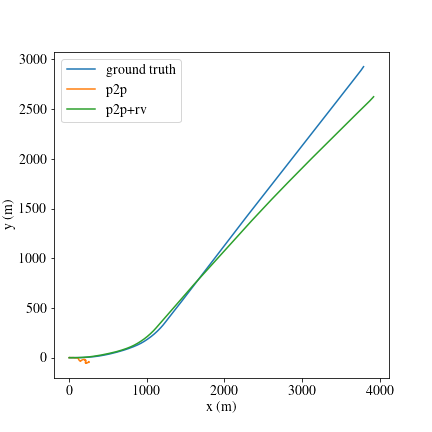

In [9]:
import os.path as osp
import numpy as np
import numpy.linalg as npla
import scipy.spatial.transform as sptf
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 14,
})

np.set_printoptions(6, suppress=True)

from pylgmath import se3op, Transformation
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.p2p import P2PErrorEvaluator as p2p_error


def align_path(T_mr_gt, T_mr_pred):
  T_gt_pred = SE3StateVar(Transformation(T_ba=np.eye(4)))

  noise_model = StaticNoiseModel(np.eye(3))
  loss_func = L2LossFunc()
  cost_terms = []
  for idx in range(len(T_mr_gt)):
    error_func = p2p_error(T_gt_pred, T_mr_gt[idx, :, 3:], T_mr_pred[idx, :, 3:])
    cost_terms.append(WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

  opt_prob = OptimizationProblem()
  opt_prob.add_state_var(T_gt_pred)
  opt_prob.add_cost_term(*cost_terms)

  gauss_newton = GaussNewtonSolver(opt_prob, verbose=True, max_iterations=100)
  gauss_newton.optimize()

  return T_gt_pred.value.matrix()


def load_pred_poses(filename):
    data = np.loadtxt(filename)
    poses = []
    for v in data:
        T_ms = np.eye(4)
        T_ms[:3, :] = v.reshape(3, 4)
        poses.append(T_ms)
    return np.array(poses)


def load_gt_poses(filename):
    """Parses a TUM file to extract the trajectory poses and timestamps.

    Args:
        filename: Path to a TUM trajectory file.

    Returns:
        (N, 4, 4) ndarray of absolute poses from the trajectory and
        (N,) ndarray of corresponding timestamps (sec).
    """
    data = np.loadtxt(filename, delimiter=' ')

    poses = []
    for tq in data[:, 1:]:
        T_mr = np.eye(4)
        T_mr[:3, :3] = sptf.Rotation.from_quat(tq[3:]).as_matrix()
        T_mr[:3, 3] = tq[:3]
        poses.append(T_mr)
    return np.array(poses)


def plot_pred_poses(ax, filename, gt_poses, label):
    pred_poses = load_pred_poses(filename)
    T_gt_pred = gt_poses[0] @ npla.inv(pred_poses[0])
    pred_poses = T_gt_pred @ pred_poses
    ax.plot(pred_poses[:, 0, 3], pred_poses[:, 1, 3], label=label)



gt_path = '/media/yuchen/T7/ASRL/data/aeva'
sequence = 'brisbane-lagoon-freeway'


fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# ground truth
gt_poses = load_gt_poses(osp.join(gt_path, sequence, 'ref_poses.txt'))
ax.plot(gt_poses[:, 0, 3], gt_poses[:, 1, 3], label='ground truth')

pred_file = '/home/yuchen/ASRL/temp/doppler_odometry/dicp/steam_p2p'
plot_pred_poses(ax, osp.join(pred_file, sequence+'_poses.txt'), gt_poses, 'p2p')

pred_file = '/home/yuchen/ASRL/temp/doppler_odometry/dicp/steam_temp'
plot_pred_poses(ax, osp.join(pred_file, sequence+'_poses.txt'), gt_poses, 'p2p+rv')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.legend()
plt.show()